In [ ]:
import pandas as pd
import numpy as np
import random
import hashlib
from datetime import datetime, timedelta

# Function to generate synthetic 'caller_id' and 'callee_id' with hashing
def generate_hashed_ids(num_entries):
    caller_ids = [f"caller_{i}" for i in range(num_entries)]
    callee_ids = [f"callee_{i}" for i in range(num_entries)]
    hashed_caller_ids = [hashlib.sha256(id.encode('utf-8')).hexdigest()[:10] for id in caller_ids]
    hashed_callee_ids = [hashlib.sha256(id.encode('utf-8')).hexdigest()[:10] for id in callee_ids]
    return hashed_caller_ids, hashed_callee_ids

# Function to generate call duration (in seconds)
def generate_call_duration(is_robocall, enforce_short=False):
    if enforce_short:
        return random.randint(10, 100)  # For specific additional short-duration calls
    return random.randint(10, 100) if is_robocall else random.randint(100, 600)

# Function to generate call type (incoming or outgoing)
def generate_call_type(is_robocall):
    return 'outgoing' if is_robocall else random.choice(['incoming', 'outgoing'])

# Function to generate disconnecting party (caller or callee)
def generate_disconnect_party(is_robocall, duration):
    return 'callee' if is_robocall and duration < 100 else random.choice(['caller', 'callee'])

# Function to generate call start and end time
def generate_call_time(is_robocall):
    if is_robocall:
        start_time = datetime(2025, 2, 10, random.choice([1, 2, 3, 4, 5, 23]), random.randint(0, 59))
    else:
        start_time = datetime(2025, 2, 10, random.randint(9, 21), random.randint(0, 59))
    end_time = start_time + timedelta(seconds=random.randint(10, 600))
    return start_time.strftime("%H:%M:%S"), end_time.strftime("%H:%M:%S")  # Convert to HH:MM:SS format

# Generate synthetic dataset
def generate_synthetic_data(num_entries=100000, extra_short_calls=200):
    caller_ids, callee_ids = generate_hashed_ids(num_entries + extra_short_calls)

    num_legitimate = num_entries // 2
    num_robocalls = num_entries - num_legitimate

    durations = []
    call_types = []
    disconnecting_parties = []
    labels = []
    start_times = []
    end_times = []

    # Generate legitimate calls
    for _ in range(num_legitimate):
        is_robocall = False
        duration = generate_call_duration(is_robocall)
        call_types.append(generate_call_type(is_robocall))
        disconnecting_parties.append(generate_disconnect_party(is_robocall, duration))
        start_time, end_time = generate_call_time(is_robocall)

        durations.append(duration)
        labels.append('legitimate')
        start_times.append(start_time)
        end_times.append(end_time)

    # Generate robocall data
    for _ in range(num_robocalls):
        is_robocall = True
        duration = generate_call_duration(is_robocall)
        call_types.append(generate_call_type(is_robocall))
        disconnecting_parties.append(generate_disconnect_party(is_robocall, duration))
        start_time, end_time = generate_call_time(is_robocall)

        durations.append(duration)
        labels.append('robocall')
        start_times.append(start_time)
        end_times.append(end_time)

    # Add extra short robocalls (10-100 seconds)
    for _ in range(extra_short_calls):
        is_robocall = True
        duration = generate_call_duration(is_robocall, enforce_short=True)
        call_types.append(generate_call_type(is_robocall))
        disconnecting_parties.append(generate_disconnect_party(is_robocall, duration))
        start_time, end_time = generate_call_time(is_robocall)

        durations.append(duration)
        labels.append('robocall')
        start_times.append(start_time)
        end_times.append(end_time)

    df = pd.DataFrame({
        'caller_id': caller_ids[:len(durations)],  # Adjusted to match final dataset size
        'callee_id': callee_ids[:len(durations)],
        'duration': durations,
        'call_type': call_types,
        'disconnecting_party': disconnecting_parties,
        'label': labels,
        'start_time': start_times,
        'end_time': end_times
    })

    return df

# Generate and save dataset
synthetic_data = generate_synthetic_data()
synthetic_data.to_csv('data.csv', index=False)

# Show preview
print(synthetic_data.head())


    caller_id   callee_id  duration call_type disconnecting_party       label  \
0  a2ea4e294e  31fd188c97       211  incoming              caller  legitimate   
1  e3176ee77c  04ec720286       172  outgoing              caller  legitimate   
2  22f0fa1a5a  086a57a20c       302  outgoing              caller  legitimate   
3  b169f4e442  f5b8f282c4       284  outgoing              callee  legitimate   
4  2ee34b2b19  4bd039bd0a       522  outgoing              caller  legitimate   

  start_time  end_time  
0   11:55:00  12:02:18  
1   21:51:00  22:01:00  
2   21:27:00  21:29:41  
3   14:33:00  14:36:48  
4   11:42:00  11:51:55  


In [ ]:
import pandas as pd
from sklearn.utils import shuffle

# Assuming your dataset is a pandas DataFrame
df = pd.read_csv('data.csv')  # Load your dataset

# Shuffle the dataset to mix legitimate and robocalls
df = shuffle(df, random_state=42)  # random_state is used to ensure reproducibility

# Save the shuffled dataset (optional)
df.to_csv('data.csv', index=False)


In [ ]:
# FOR CDR DATASET PREPROCESSING AND CALCULATING SNA FEATURES AND STORING THE RESULTS
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load CDR dataset
cdr_df = pd.read_csv('data_cdr.csv')

# Preprocess CDR Dataset
cdr_df['call_type'] = LabelEncoder().fit_transform(cdr_df['call_type'])
cdr_df['disconnecting_party'] = LabelEncoder().fit_transform(cdr_df['disconnecting_party'])
cdr_df['label'] = LabelEncoder().fit_transform(cdr_df['label'])

# 🔹 **Fix: Encode caller_id as well**
cdr_df['caller_id'] = LabelEncoder().fit_transform(cdr_df['caller_id'])
cdr_df['callee_id'] = LabelEncoder().fit_transform(cdr_df['callee_id'])

# SNA Feature Calculation Optimization (Removed Betweenness Centrality)
def calculate_sna_features(df):
    # Create graph from CDR data where caller_id and callee_id are nodes
    G = nx.Graph()
    for _, row in df.iterrows():
        caller, callee = row['caller_id'], row['callee_id']
        G.add_edge(caller, callee)

    # Calculate degree centrality in one go
    degree_centrality = nx.degree_centrality(G)

    # Assign centrality values to the dataset
    df['degree_centrality'] = df['caller_id'].map(degree_centrality)

    # Calculate Repetitive Index and Engagement Score using efficient groupby
    repetitive_index = df.groupby('caller_id')['callee_id'].count().reset_index(name='repetitive_index')
    engagement_score = df.groupby('caller_id')['duration'].sum().reset_index(name='engagement_score')

    # Merge the results back into the original DataFrame
    df = df.merge(repetitive_index, on='caller_id', how='left')
    df = df.merge(engagement_score, on='caller_id', how='left')

    return df

# Apply optimized SNA features calculation (excluding Betweenness Centrality)
cdr_df = calculate_sna_features(cdr_df)

# Ensure the final dataset contains the relevant 8 features
features = ['caller_id', 'callee_id', 'call_type', 'duration', 'disconnecting_party', 'degree_centrality', 'repetitive_index', 'engagement_score']
cdr_df = cdr_df[features + ['label']]  # Keep only the features and the label for training

# Save the processed CDR dataset with the selected features
cdr_df.to_csv('processed_cdr_data.csv', index=False)

### **Define X, y and Split Dataset**
X = cdr_df.drop(columns=['label'])  # Features
y = cdr_df['label']  # Target (robocall or legitimate)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler (Only if needed for your model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save preprocessed training & test data for later use
pd.DataFrame(X_train_scaled, columns=features).to_csv('X_train_scaled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=features).to_csv('X_test_scaled.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)


In [ ]:
#FOR SMS SPAM DATASET TEXT PREPROCESSING IS DONE(TOKENIZATION, STOPWORDS REMOVAL, ENCODING LABELS)
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define column names since the dataset doesn't have headers
column_names = ['content', 'label']

# Load SMS Spam dataset and assign column names
sms_df = pd.read_csv('data_audio.csv', names=column_names, dtype={'content': str, 'label': str}, low_memory=False)

# Handle missing values
sms_df = sms_df.dropna(subset=['content'])

# Encode labels (Spam -> 1, Ham -> 0)
sms_df['label'] = LabelEncoder().fit_transform(sms_df['label'])

# Text preprocessing (tokenization, stopwords removal, etc.)
tfidf = TfidfVectorizer(stop_words='english')
X_sms = tfidf.fit_transform(sms_df['content']).toarray()
y_sms = sms_df['label'].values

# Save processed SMS data
np.save('X_sms.npy', X_sms)
np.save('y_sms.npy', y_sms)

print("Preprocessing completed successfully!")


Preprocessing completed successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Accuracy: 0.9738617200674536
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1061
           1       0.99      0.76      0.86       125

    accuracy                           0.97      1186
   macro avg       0.98      0.88      0.92      1186
weighted avg       0.97      0.97      0.97      1186



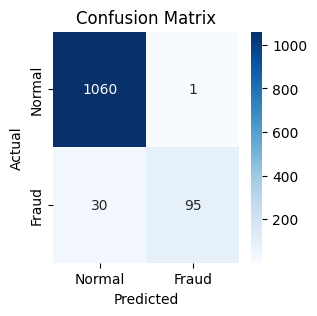

In [ ]:
!pip install pydub
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pydub import AudioSegment
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib  # For saving and loading the model
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary resources for text preprocessing
nltk.download('punkt')
nltk.download('stopwords')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')  # This line downloads the missing data

# Load your dataset
data = pd.read_csv("data_audio.csv")

# Map the labels for easier processing
data['Label'] = data['Label'].map({'fraud': 1, 'normal': 0})

# Preprocess text function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))  # Define stopwords
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing to the content column
data['Processed_Content'] = data['Content'].apply(preprocess_text)

# Vectorize the processed text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['Processed_Content'])
y = data['Label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model and the vectorizer
joblib.dump(model, 'fraud_detection_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# Test the model
y_pred = model.predict(X_test)

# Print accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression Accuracy: 99.69%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10021
           1       0.99      1.00      1.00     10018

    accuracy                           1.00     20039
   macro avg       1.00      1.00      1.00     20039
weighted avg       1.00      1.00      1.00     20039

Logistic Regression Confusion Matrix:
[[ 9959    62]
 [    0 10018]]


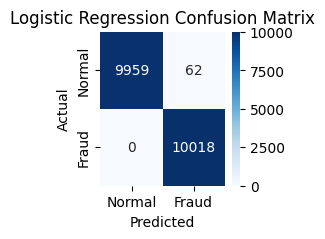

Neural Network Accuracy: 99.90%
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10021
           1       1.00      1.00      1.00     10018

    accuracy                           1.00     20039
   macro avg       1.00      1.00      1.00     20039
weighted avg       1.00      1.00      1.00     20039

Neural Network Confusion Matrix:
[[10008    13]
 [    7 10011]]


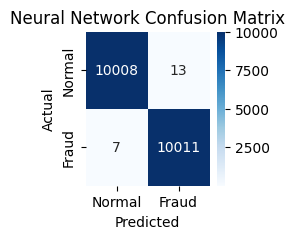

Model and scaler saved successfully.


In [ ]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

# Load preprocessed CDR dataset
cdr_df = pd.read_csv('processed_cdr_data.csv')

# Apply Label Encoding to caller_id and callee_id (converts them to numerical values)
label_encoder = LabelEncoder()
cdr_df['caller_id'] = label_encoder.fit_transform(cdr_df['caller_id'])
cdr_df['callee_id'] = label_encoder.fit_transform(cdr_df['callee_id'])

# Construct a call graph using NetworkX
G = nx.from_pandas_edgelist(cdr_df, source='caller_id', target='callee_id', create_using=nx.DiGraph())

# Compute Degree Centrality and add it as a feature
degree_centrality = nx.degree_centrality(G)
cdr_df['degree_centrality'] = cdr_df['caller_id'].map(degree_centrality)

# Select only the required 8 features, including callee_id
X_cdr = cdr_df[['caller_id', 'callee_id', 'duration', 'call_type', 'disconnecting_party',
                'engagement_score', 'repetitive_index', 'degree_centrality']]
y_cdr = cdr_df['label']  # Target variable

# Normalize the features (all features including caller_id and callee_id)
scaler = StandardScaler()
X_cdr_scaled = scaler.fit_transform(X_cdr)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cdr_scaled, y_cdr, test_size=0.2, random_state=42)

# Train a Logistic Regression Model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

from sklearn.impute import SimpleImputer

# Create an imputer with mean strategy
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"

# Fit and transform the test data
X_test = imputer.fit_transform(X_test)

# Evaluate Logistic Regression model
y_pred = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")

# Print additional metrics for Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix for Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train a Neural Network Model (MLP Classifier)
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate Neural Network model
y_pred_mlp = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"Neural Network Accuracy: {mlp_accuracy * 100:.2f}%")

# Print additional metrics for Neural Network
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))

# Plot confusion matrix for Neural Network
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the best performing model
best_model = log_reg_model if log_reg_accuracy > mlp_accuracy else mlp_model
joblib.dump(best_model, 'spam_call_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")


In [ ]:
!pip install SpeechRecognition
!pip install pydub  # For audio file conversion


In [ ]:
import numpy as np
import joblib  # For loading the saved model

# Load the pre-trained models
cdr_model = joblib.load('spam_call_model.pkl')  # CDR-based trained model
scaler = joblib.load('scaler.pkl')  # Load the trained scaler

# Function to calculate SNA features (based on the call history and caller details)
def calculate_sna_features(caller_details, call_history):
    caller_id = caller_details['caller_id']

    # Ensure there is always a valid value for each feature
    repetitive_index = call_history.get(caller_id, {}).get('repeated_calls', 0)
    engagement_score = caller_details['duration'] / 100  # Scale down duration
    degree_centrality = len(call_history.get(caller_id, {}).get('connected_numbers', []))

    return [repetitive_index, engagement_score, degree_centrality]

# Function to predict using the CDR-based model
def predict_using_cdr(caller_details, call_history):
    sna_features = calculate_sna_features(caller_details, call_history)

    # Prepare the input features for the model
    X = np.array([
        caller_details['duration'],
        caller_details['call_type'],
        caller_details['disconnecting_party'],
        int(caller_details['caller_id']),
        int(caller_details['callee_id']),
        *sna_features  # Ensure this is always 3 features
    ]).reshape(1, -1)

    # Scale the features using the pre-trained scaler
    X_scaled = scaler.transform(X)

    # Get the prediction from the model (1 for Spam, 0 for Legitimate)
    prediction = cdr_model.predict(X_scaled)

    # Return the predicted label (Spam/Legitimate)
    return "Spam" if prediction[0] == 1 else "Legitimate"

# Function to get user input
def get_user_input():
    caller_id = input("Enter the caller ID (e.g., 1234567890): ")
    callee_id = input("Enter the callee ID (e.g., 9876543210): ")
    call_type = int(input("Enter the call type (1 for outgoing, 0 for incoming): "))
    duration = int(input("Enter the call duration in seconds (e.g., 180): "))
    disconnecting_party = int(input("Enter the disconnecting party (1 if caller disconnected, 0 otherwise): "))

    caller_details = {
        'caller_id': caller_id,
        'callee_id': callee_id,
        'call_type': call_type,
        'duration': duration,
        'disconnecting_party': disconnecting_party
    }
    return caller_details

# Main execution
caller_details = get_user_input()
call_history = {}  # Assuming an empty call history for simplicity

# Predict using the CDR model
classification = predict_using_cdr(caller_details, call_history)
print("The details are processed and stored")


Enter the caller ID (e.g., 1234567890): 7894561230
Enter the callee ID (e.g., 9876543210): 9876543210
Enter the call type (1 for outgoing, 0 for incoming): 0
Enter the call duration in seconds (e.g., 180): 20
Enter the disconnecting party (1 if caller disconnected, 0 otherwise): 0
The details are processed and stored


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Import necessary libraries
import joblib  # For loading the saved model
from pydub import AudioSegment
import speech_recognition as sr
from google.colab import files

# Function to convert MP3 to WAV
def mp3_to_wav(mp3_filename):
    sound = AudioSegment.from_mp3(mp3_filename)
    wav_filename = mp3_filename.replace('.mp3', '.wav')
    sound.export(wav_filename, format="wav")
    return wav_filename

# Function to recognize speech and convert to text
def recognize_speech(wav_filename):
    recognizer = sr.Recognizer()
    with sr.AudioFile(wav_filename) as source:
        audio = recognizer.record(source)
    try:
        # Use Google Web Speech API (can be replaced with other recognizers)
        text = recognizer.recognize_google(audio)
        return text
    except sr.UnknownValueError:
        return "Could not understand audio"
    except sr.RequestError as e:
        return f"Could not request results; {e}"

# Function to classify new audio
def classify_audio(mp3_filename):
    # Load the saved model and vectorizer
    model = joblib.load('fraud_detection_model.pkl')
    vectorizer = joblib.load('vectorizer.pkl')

    wav_filename = mp3_to_wav(mp3_filename)  # Convert MP3 to WAV
    recognized_text = recognize_speech(wav_filename)  # Recognize speech and convert to text
    processed_text = preprocess_text(recognized_text)  # Preprocess the recognized text
    text_vectorized = vectorizer.transform([processed_text])  # Vectorize the text
    prediction = model.predict(text_vectorized)  # Predict the label
    return recognized_text, "Spam" if prediction[0] == 1 else "Legitimate"  # Return text and result

# Upload an audio file from the user
uploaded = files.upload()

# Get the uploaded file name
mp3_file = next(iter(uploaded))  # Fetch the first uploaded file

# Classify the uploaded audio file and get the recognized text
recognized_text, nlp_prediction = classify_audio(mp3_file)  # Classify the audio

# Print the recognized audio-to-text conversion
print(f"Recognized Text from Audio: {recognized_text}")

def get_final_classification(nlp_prediction, classification):
    # Convert the string labels to numeric values
    nlp_prediction_numeric = 1 if nlp_prediction == "fraud" else 0
    classification_numeric = 1 if classification == "Spam" else 0

    # Calculate the final score
    final_score = (0.5 * nlp_prediction_numeric) + (0.5 * classification_numeric)

    # Return the classification based on the final score
    return "Legitimate" if final_score >= 0.5 else "Spam"

# Example classification from another model (e.g., CDR-based model)
classification = "Spam"  # This should be based on your CDR model prediction

final_classification = get_final_classification(nlp_prediction, classification)

print(f"The final combined output is: {nlp_prediction}")


Saving audio4.mp3 to audio4 (2).mp3
Recognized Text from Audio: hello sir I am from jio customer care in 23 hours your sim will be closed do you want to activate it
The final combined output is: Spam
